# Paths

In [1]:
## local machine
src_path = '../src'
lib_path = '../lib/'
input_path = '../../kaggle/input/home-credit-default-risk/'

In [2]:
# # Google Colab
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

# # After executing above, Drive files will be accessible in path "/content/drive/MyDrive"

# # Google Colab
# src_path = '/content/drive/MyDrive/kaggle/src'
# lib_path = '/content/drive/MyDrive/kaggle/lib'
# input_path = '/content/drive/MyDrive/kaggle/input/home-credit-default-risk/'

In [3]:
# # Kaggle
# src_path = '/kaggle/src'
# lib_path = '/kaggle/lib/'
# input_path = '/kaggle/input/home-credit-default-risk/'

# Imports

In [4]:
import pandas as pd
pd.set_option("display.max_columns", 200)

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TunedThresholdClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, make_scorer, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

from sklearn import set_config
set_config(transform_output="pandas")

from xgboost import XGBClassifier, XGBRFClassifier

from lightgbm import LGBMClassifier

from category_encoders import HashingEncoder

import joblib
saved = joblib.load(lib_path + "data_processing.joblib")
preprocessor = saved["preprocessor"]
non_co_cols = saved["non_co_cols"]
merged_application_test = saved["merged_application_train"]

import sys
sys.path.insert(0, src_path)
from eval_classification import eval_classification
del sys.path[0]

In [97]:
# split data
X = merged_application_test.drop(columns=["TARGET", "SK_ID_CURR"])
y = merged_application_test["TARGET"].copy()

In [ ]:
# split data 70/20 for training and testing and hold 5 and 5
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)
X_test, X_stack, y_test, y_stack = train_test_split(X_test, y_test, train_size=(2/3), test_size=(1/3), random_state=42)
X_stack, X_calib, y_stack, y_calib = train_test_split(X_stack, y_stack, train_size=0.5, test_size=0.5, random_state=42)

In [ ]:
# fit data on preprocessor
preprocessor.fit(X_train, y_train)

# transform data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
X_stack = preprocessor.transform(X_stack)
X_calib = preprocessor.transform(X_calib)

In [ ]:
# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
X_train.drop(columns=non_co_cols, inplace=True)
X_test.drop(columns=non_co_cols, inplace=True)
X_stack.drop(columns=non_co_cols, inplace=True)
X_calib.drop(columns=non_co_cols, inplace=True)

# Model Testing

## Logistic Regression

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    197845             0       0.96      0.69      0.80     56514 
           1       0.16      0.67      0.26     17412             1       0.16      0.67      0.26      4988 
                                                                                                             
    accuracy                           0.69    215257      accuracy                           0.69     61502 
   macro avg       0.56      0.68      0.53    215257     macro avg       0.56      0.68      0.53     61502 
weighted avg       0.90      0.69      0.76    215257  weighted avg       0.89      0.69      0.76     61502 


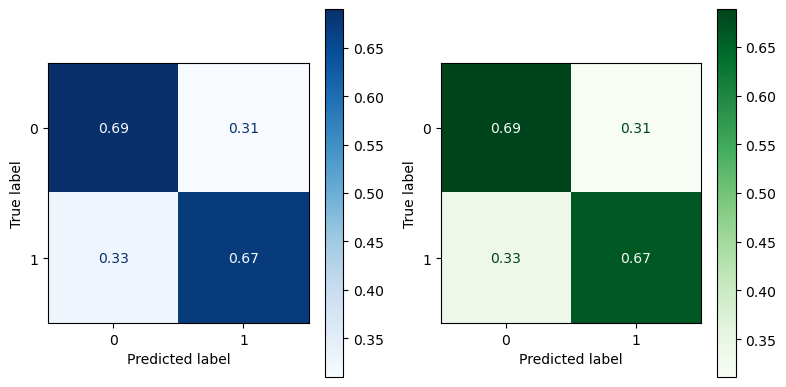

In [ ]:
lr = LogisticRegression(class_weight="balanced", random_state=42).fit(X_train, y_train)

lr_results = eval_classification(lr, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression")

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    197845             0       0.96      0.69      0.80     56514 
           1       0.16      0.67      0.26     17412             1       0.16      0.67      0.26      4988 
                                                                                                             
    accuracy                           0.69    215257      accuracy                           0.69     61502 
   macro avg       0.56      0.68      0.53    215257     macro avg       0.56      0.68      0.53     61502 
weighted avg       0.90      0.69      0.76    215257  weighted avg       0.89      0.69      0.76     61502 


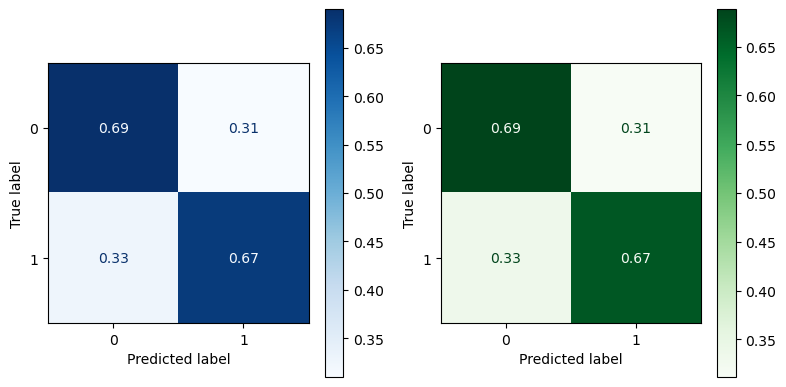

In [ ]:
lr_tuned = LogisticRegressionCV(Cs=9, max_iter=1000, 
                                class_weight="balanced", scoring="roc_auc", 
                                n_jobs=-1, random_state=42).fit(X_train, y_train)

logreg_cv_results = eval_classification(logreg_cv, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression CV", results_frame=logreg_results)

In [11]:
logreg_cv_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922


In [12]:
logreg_cv.get_params()

{'Cs': 9,
 'class_weight': 'balanced',
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

## Decision Trees

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    197845             0       0.93      0.92      0.92     56514 
           1       1.00      1.00      1.00     17412             1       0.15      0.16      0.15      4988 
                                                                                                             
    accuracy                           1.00    215257      accuracy                           0.86     61502 
   macro avg       1.00      1.00      1.00    215257     macro avg       0.54      0.54      0.54     61502 
weighted avg       1.00      1.00      1.00    215257  weighted avg       0.86      0.86      0.86     61502 


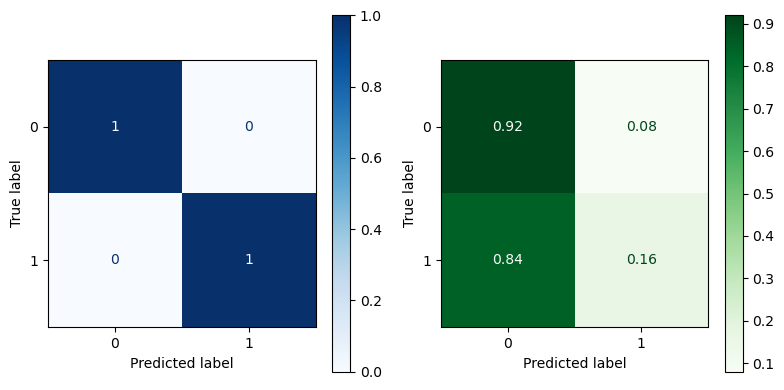

In [ ]:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced").fit(X_train, y_train)

dt_results = eval_classification(dt, X_train, y_train, X_test, y_test,
                                  model_name="Decision Tree", results_frame=logreg_cv_results)

In [14]:
dt.get_depth()

84

In [15]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.71      0.82    197845             0       0.95      0.71      0.82     56514 
           1       0.16      0.64      0.26     17412             1       0.16      0.60      0.25      4988 
                                                                                                             
    accuracy                           0.71    215257      accuracy                           0.70     61502 
   macro avg       0.56      0.67      0.54    215257     macro avg       0.55      0.66      0.53     61502 
weighted avg       0.89      0.71      0.77    215257  weighted avg       0.89      0.70      0.77     61502 


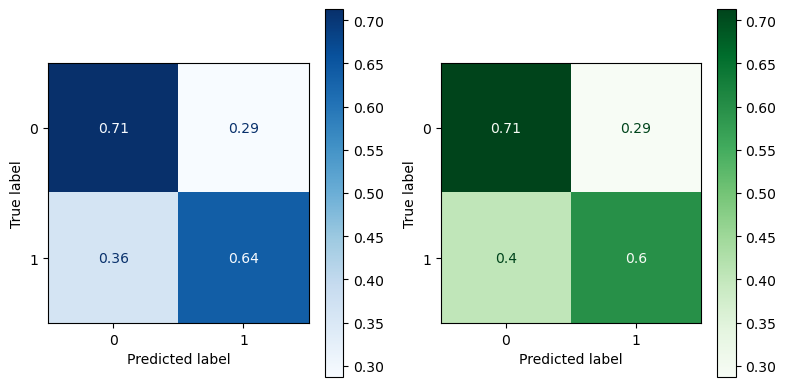

In [ ]:
dt_params = {'max_depth': [None, 2, 3, 4, 7, 21, 84],
             'max_features': [None, 
}
dt_gs = GridSearchCV(dt, dt_params, scoring="roc_auc", n_jobs=-1)
dt_gs.fit(X_train, y_train)
dt_cv = dt_gs.best_estimator_.fit(X_train, y_train)

dt_cv_results = eval_classification(dt_cv, X_train, y_train, X_test, y_test,
                                  model_name="Decision Tree CV", results_frame=dt_results)

In [21]:
dt_cv.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [19]:
dt_cv_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922
Decision Tree,1.000000,0.857940,1.000000,0.148113,1.000000,0.158180,1.000000,0.152981,1.000000,0.538940
Decision Tree CV,0.760203,0.758447,0.169903,0.166035,0.505571,0.491780,0.254334,0.248254,0.697200,0.692345


                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.71      0.82    197845             0       0.95      0.71      0.82     56514 
           1       0.16      0.64      0.26     17412             1       0.16      0.60      0.25      4988 
                                                                                                             
    accuracy                           0.71    215257      accuracy                           0.70     61502 
   macro avg       0.56      0.67      0.54    215257     macro avg       0.55      0.66      0.53     61502 
weighted avg       0.89      0.71      0.77    215257  weighted avg       0.89      0.70      0.77     61502 


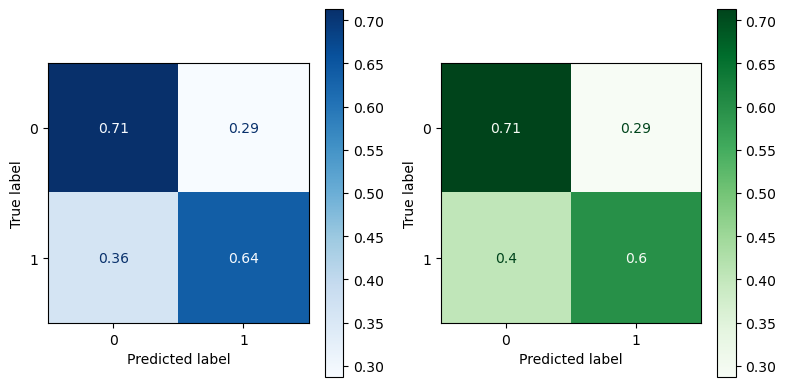

In [22]:
bdt = AdaBoostClassifier(dt_cv, random_state=42).fit(X_train, y_train)

bdt_results = eval_classification(bdt, X_train, y_train, X_test, y_test,
                                  model_name="AdaBoosted Decision Tree", results_frame=dt_cv_results)

In [23]:
bdt_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922
Decision Tree,1.000000,0.857940,1.000000,0.148113,1.000000,0.158180,1.000000,0.152981,1.000000,0.538940
Decision Tree CV,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.733137,0.706668
AdaBoosted Decision Tree,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.712692,0.688920


## Random Forests

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    197845             0       0.92      1.00      0.96     56514 
           1       1.00      1.00      1.00     17412             1       0.54      0.00      0.01      4988 
                                                                                                             
    accuracy                           1.00    215257      accuracy                           0.92     61502 
   macro avg       1.00      1.00      1.00    215257     macro avg       0.73      0.50      0.48     61502 
weighted avg       1.00      1.00      1.00    215257  weighted avg       0.89      0.92      0.88     61502 


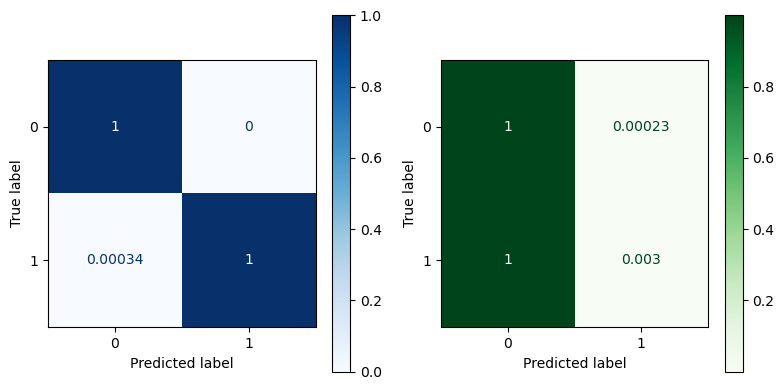

In [24]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced_subsample").fit(X_train, y_train)

rf_results = eval_classification(rf, X_train, y_train, X_test, y_test,
                                  model_name="Random Forest", results_frame=bdt_results)

In [25]:
estimators = rf.estimators_
depths = [est.get_depth() for est in estimators]
max(depths)

74

In [41]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    197845             0       0.92      1.00      0.96     56514 
           1       1.00      1.00      1.00     17412             1       0.45      0.01      0.03      4988 
                                                                                                             
    accuracy                           1.00    215257      accuracy                           0.92     61502 
   macro avg       1.00      1.00      1.00    215257     macro avg       0.69      0.51      0.49     61502 
weighted avg       1.00      1.00      1.00    215257  weighted avg       0.88      0.92      0.88     61502 


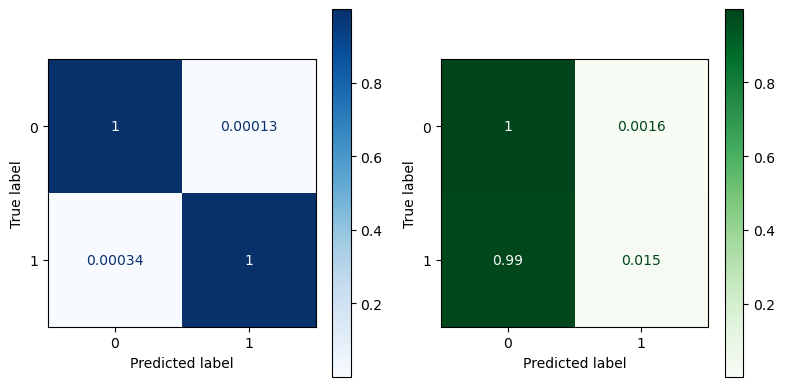

In [42]:
rf_params = {"n_estimators" : [20, 40, 60, 80, 100],
             "max_depth" : [2, 37, 74]}
rf_gs = GridSearchCV(rf, rf_params, scoring="roc_auc", n_jobs=-1)
rf_gs.fit(X_train, y_train)
rf_cv = rf_gs.best_estimator_.fit(X_train, y_train)

rf_cv_results = eval_classification(rf_cv, X_train, y_train, X_test, y_test,
                                  model_name="Random Forest CV", results_frame=rf_results)

In [43]:
rf_cv.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 37,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [44]:
rf_cv_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922
Decision Tree,1.000000,0.857940,1.000000,0.148113,1.000000,0.158180,1.000000,0.152981,1.000000,0.538940
Decision Tree CV,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.733137,0.706668
AdaBoosted Decision Tree,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.712692,0.688920
Random Forest,0.999972,0.918929,1.000000,0.535714,0.999655,0.003007,0.999828,0.005981,1.000000,0.733311
Random Forest CV,0.999851,0.918653,0.998508,0.453988,0.999655,0.014836,0.999082,0.028732,0.999998,0.729412


## Gradient Boosting Models

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.73      0.83    197845             0       0.96      0.72      0.82     56514 
           1       0.19      0.74      0.30     17412             1       0.17      0.68      0.28      4988 
                                                                                                             
    accuracy                           0.73    215257      accuracy                           0.71     61502 
   macro avg       0.58      0.73      0.57    215257     macro avg       0.57      0.70      0.55     61502 
weighted avg       0.91      0.73      0.79    215257  weighted avg       0.90      0.71      0.78     61502 


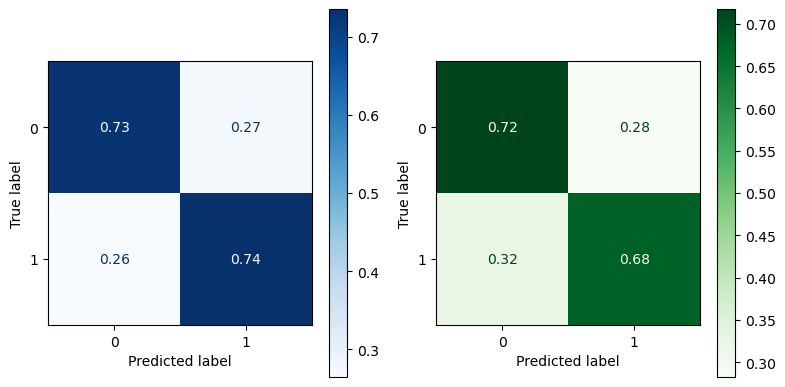

In [45]:
hgb = HistGradientBoostingClassifier(scoring="roc_auc", random_state=42, class_weight="balanced", max_iter=1000).fit(X_train, y_train)

hgb_results = eval_classification(hgb, X_train, y_train, X_test, y_test,
                                  model_name="Histogram-based Gradient Boosting Tree", results_frame=rf_cv_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      1.00      0.96    197845             0       0.92      0.99      0.96     56514 
           1       0.84      0.13      0.22     17412             1       0.45      0.05      0.10      4988 
                                                                                                             
    accuracy                           0.93    215257      accuracy                           0.92     61502 
   macro avg       0.89      0.56      0.59    215257     macro avg       0.69      0.52      0.53     61502 
weighted avg       0.92      0.93      0.90    215257  weighted avg       0.88      0.92      0.89     61502 


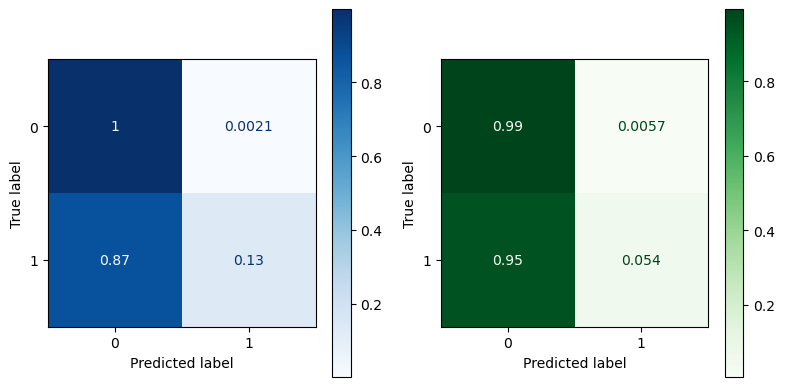

In [46]:
xgb = XGBClassifier(eval_metric="auc", objective="binary:logistic", random_state=42).fit(X_train, y_train)

xgb_results = eval_classification(xgb, X_train, y_train, X_test, y_test,
                                  model_name="XGBoost", results_frame=hgb_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.99      0.98    197845             0       0.93      0.97      0.95     56514 
           1       0.87      0.65      0.75     17412             1       0.33      0.16      0.21      4988 
                                                                                                             
    accuracy                           0.96    215257      accuracy                           0.91     61502 
   macro avg       0.92      0.82      0.86    215257     macro avg       0.63      0.56      0.58     61502 
weighted avg       0.96      0.96      0.96    215257  weighted avg       0.88      0.91      0.89     61502 


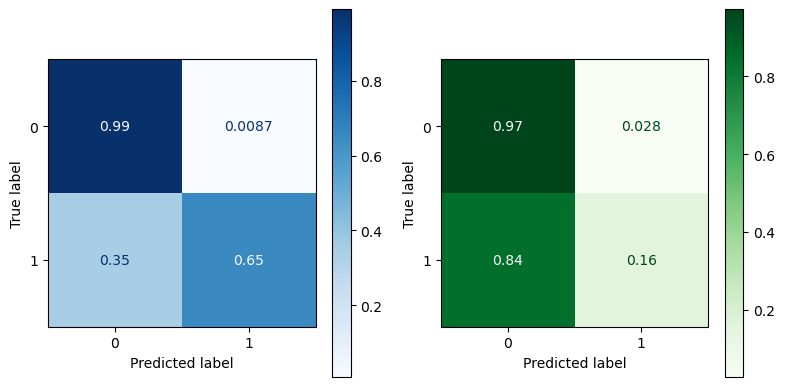

In [47]:
xgbrf = XGBRFClassifier(eval_metric="auc", objective="binary:logistic", seed=42, max_depth=37).fit(X_train, y_train)

xgbrf_results = eval_classification(xgbrf, X_train, y_train, X_test, y_test,
                                  model_name="XGBoost Random Forest", results_frame=xgb_results)

In [48]:
xgbrf_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922
Decision Tree,1.000000,0.857940,1.000000,0.148113,1.000000,0.158180,1.000000,0.152981,1.000000,0.538940
Decision Tree CV,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.733137,0.706668
AdaBoosted Decision Tree,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.712692,0.688920
Random Forest,0.999972,0.918929,1.000000,0.535714,0.999655,0.003007,0.999828,0.005981,1.000000,0.733311
Random Forest CV,0.999851,0.918653,0.998508,0.453988,0.999655,0.014836,0.999082,0.028732,0.999998,0.729412
Histogram-based Gradient Boosting Tree,0.728292,0.714367,0.192004,0.174911,0.735297,0.678428,0.304496,0.278118,0.809763,0.766911
XGBoost,0.927538,0.918019,0.844867,0.454082,0.127613,0.053528,0.221734,0.095768,0.870633,0.756757
XGBoost Random Forest,0.963890,0.905629,0.867929,0.327703,0.652941,0.155573,0.745239,0.210984,0.987932,0.738675


## Naive Bayes algorithms

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.03      0.06    197845             0       0.96      0.03      0.06     56514 
           1       0.08      0.98      0.15     17412             1       0.08      0.98      0.15      4988 
                                                                                                             
    accuracy                           0.11    215257      accuracy                           0.11     61502 
   macro avg       0.52      0.51      0.11    215257     macro avg       0.52      0.51      0.11     61502 
weighted avg       0.89      0.11      0.07    215257  weighted avg       0.89      0.11      0.07     61502 


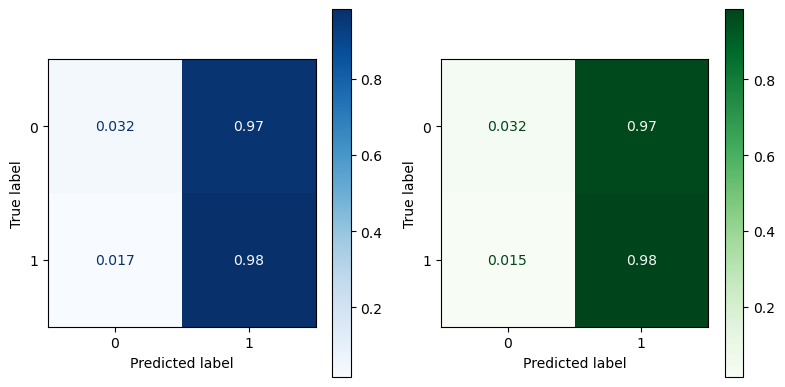

In [49]:
gnb = GaussianNB().fit(X_train, y_train)

gnb_results = eval_classification(gnb, X_train, y_train, X_test, y_test,
                                  model_name="Gaussian", results_frame=xgbrf_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      0.92      0.93    197845             0       0.93      0.92      0.93     56514 
           1       0.19      0.21      0.20     17412             1       0.19      0.20      0.20      4988 
                                                                                                             
    accuracy                           0.87    215257      accuracy                           0.86     61502 
   macro avg       0.56      0.57      0.56    215257     macro avg       0.56      0.56      0.56     61502 
weighted avg       0.87      0.87      0.87    215257  weighted avg       0.87      0.86      0.87     61502 


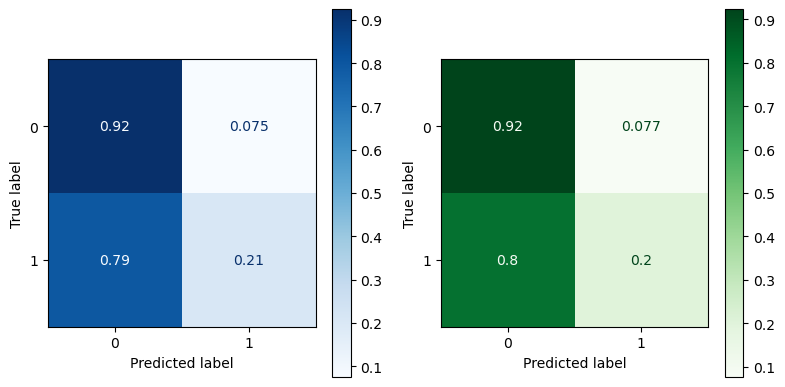

In [50]:
bnb = BernoulliNB().fit(X_train, y_train)

bnb_results = eval_classification(bnb, X_train, y_train, X_test, y_test,
                                  model_name="Bernoulli", results_frame=gnb_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.92      1.00      0.96    197845             0       0.92      1.00      0.96     56514 
           1       0.43      0.00      0.00     17412             1       0.29      0.00      0.00      4988 
                                                                                                             
    accuracy                           0.92    215257      accuracy                           0.92     61502 
   macro avg       0.67      0.50      0.48    215257     macro avg       0.60      0.50      0.48     61502 
weighted avg       0.88      0.92      0.88    215257  weighted avg       0.87      0.92      0.88     61502 


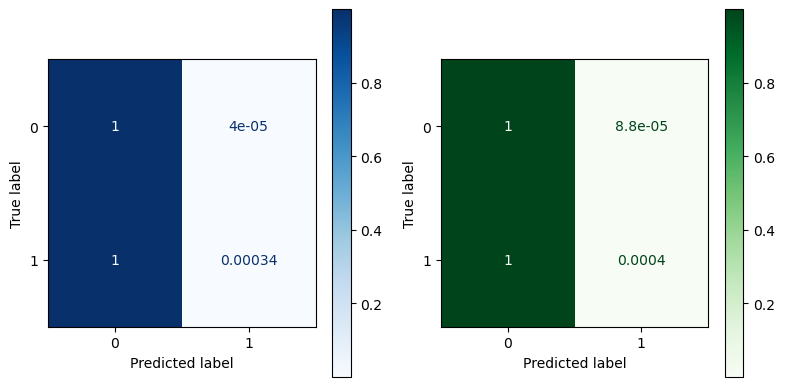

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [69]:
lsvc = LinearSVC().fit(X_train, y_train)

lsvc_results = eval_classification(lsvc, X_train, y_train, X_test, y_test,
                                  model_name="Linear SVC", results_frame=bnb_results)

# Stacking Classifier

## First we need to pick which models to stack

In [72]:
bnb_results.style.background_gradient(vmin=0, vmax=1)

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922
Decision Tree,1.000000,0.857940,1.000000,0.148113,1.000000,0.158180,1.000000,0.152981,1.000000,0.538940
Decision Tree CV,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.733137,0.706668
AdaBoosted Decision Tree,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.712692,0.688920
Random Forest,0.999972,0.918929,1.000000,0.535714,0.999655,0.003007,0.999828,0.005981,1.000000,0.733311
Random Forest CV,0.999851,0.918653,0.998508,0.453988,0.999655,0.014836,0.999082,0.028732,0.999998,0.729412
Histogram-based Gradient Boosting Tree,0.728292,0.714367,0.192004,0.174911,0.735297,0.678428,0.304496,0.278118,0.809763,0.766911
XGBoost,0.927538,0.918019,0.844867,0.454082,0.127613,0.053528,0.221734,0.095768,0.870633,0.756757
XGBoost Random Forest,0.963890,0.905629,0.867929,0.327703,0.652941,0.155573,0.745239,0.210984,0.987932,0.738675


/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.73      0.83    197845             0       0.96      0.72      0.82     56514 
           1       0.20      0.74      0.31     17412             1       0.18      0.68      0.28      4988 
                                                                                                             
    accuracy                           0.73    215257      accuracy                           0.72     61502 
   macro avg       0.58      0.74      0.57    215257     macro avg       0.57      0.70      0.55     61502 
weighted avg       0.91      0.73      0.79    215257  weighted avg       0.90      0.72      0.78     61502 


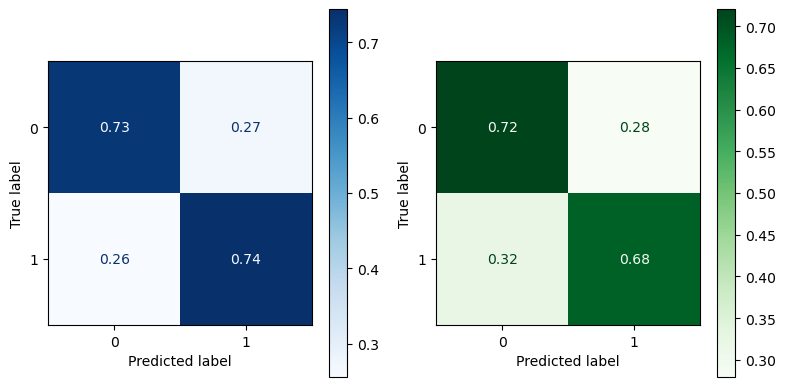

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


In [122]:
# utilizing test data results to pick classifiers, selecting by ROC AUC score, then f1 score, then recall

            #   ('logreg_cv', logreg_cv), # #3: recall, #4: f1 (untuned was #3 but picking this instead)
            #   ('svc', LinearSVC(random_state=42, class_weight="balanced"))] # adding for variety
            #   ('gnb', gnb)] # #1: recall
            #   ('xgbrf', xgbrf), # random forest for randomness ;)



estimators = [('hgb', hgb), # #1: ROC AUC, f1 #2: recall
              ('xgb', xgb), # #2: ROC AUC('gnb', gnb), # #1: recall
              ('logreg', logreg), # #3: ROC AUC, #2 f1
              ('dt', dt), # #3 f1 of different type than above
              ('svc', LinearSVC(random_state=42, class_weight="balanced").fit(X_train, y_train))] # adding for variety

stacked_clf = StackingClassifier(estimators=estimators, n_jobs=-1,
                                 final_estimator=logreg_cv, cv="prefit").fit(X_stack, y_stack)

stacked_clf_results = eval_classification(stacked_clf, X_train, y_train, X_test, y_test, 
                                          model_name="Stacked Classifier", results_frame=bnb_results)

In [123]:
stacked_clf_results.style.background_gradient()

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.688647,0.686970,0.160524,0.158756,0.673616,0.665196,0.259265,0.256335,0.745769,0.739989
Logistic Regression CV,0.688749,0.686758,0.160526,0.158690,0.673329,0.665397,0.259246,0.256264,0.745610,0.739922
Decision Tree,1.000000,0.857940,1.000000,0.148113,1.000000,0.158180,1.000000,0.152981,1.000000,0.538940
Decision Tree CV,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.733137,0.706668
AdaBoosted Decision Tree,0.706783,0.703636,0.163315,0.155216,0.636630,0.597434,0.259946,0.246413,0.712692,0.688920
Random Forest,0.999972,0.918929,1.000000,0.535714,0.999655,0.003007,0.999828,0.005981,1.000000,0.733311
Random Forest CV,0.999851,0.918653,0.998508,0.453988,0.999655,0.014836,0.999082,0.028732,0.999998,0.729412
Histogram-based Gradient Boosting Tree,0.728292,0.714367,0.192004,0.174911,0.735297,0.678428,0.304496,0.278118,0.809763,0.766911
XGBoost,0.927538,0.918019,0.844867,0.454082,0.127613,0.053528,0.221734,0.095768,0.870633,0.756757
XGBoost Random Forest,0.963890,0.905629,0.867929,0.327703,0.652941,0.155573,0.745239,0.210984,0.987932,0.738675


# Export and Submission

## Import test data and preliminary 

In [82]:
test_data_file = "application_test.csv"
application_test = pd.read_csv(input_path + test_data_file)

bureau_loans_and_balances = pd.read_csv(lib_path + "bureau_loans_and_balances.csv")

installments_payments = pd.read_csv(input_path + "installments_payments.csv")
POS_CASH_balance = pd.read_csv(input_path + "POS_CASH_balance.csv")
credit_card_balance = pd.read_csv(input_path + "credit_card_balance.csv")

application_test = pd.merge(application_test, bureau_loans_and_balances, how="left", on="SK_ID_CURR")

idx = pd.DataFrame(application_test['SK_ID_CURR'])


## Processing

In [83]:
# INSTALL steps
installments_payments.drop(columns="SK_ID_PREV", inplace=True)
installments_payments.columns = [col + "_INSTALL" for col in installments_payments.columns]
merge_INSTALL = pd.merge(idx, installments_payments, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_INSTALL")
merge_INSTALL.drop(columns="SK_ID_CURR_INSTALL", inplace=True)
merge_INSTALL = merge_INSTALL.sort_values(by="NUM_INSTALMENT_NUMBER_INSTALL", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# POS steps
POS_CASH_balance.drop(columns="SK_ID_PREV", inplace=True)
POS_CASH_balance.columns = [col + "_POS" for col in POS_CASH_balance.columns]
merge_POS = pd.merge(idx, POS_CASH_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_POS")
merge_POS.drop(columns="SK_ID_CURR_POS", inplace=True)
merge_POS = merge_POS.sort_values(by="MONTHS_BALANCE_POS", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# CC step
credit_card_balance.drop(columns="SK_ID_PREV", inplace=True)
credit_card_balance.columns = [col + "_CC" for col in credit_card_balance.columns]
merge_CC = pd.merge(idx, credit_card_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_CC")
merge_CC.drop(columns="SK_ID_CURR_CC", inplace=True)
merge_CC = merge_CC.sort_values(by="MONTHS_BALANCE_CC", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# Merge down filtered data
balances_and_payments = pd.merge(merge_INSTALL, merge_POS, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")
balances_and_payments = pd.merge(balances_and_payments, merge_CC, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")

# Drop object columns
# balances_and_payments.select_dtypes(include="object")
balances_and_payments.drop(labels=["NAME_CONTRACT_STATUS_POS", "NAME_CONTRACT_STATUS_CC"], axis=1, inplace=True)

# Merge down onto test file
application_test = pd.merge(application_test, balances_and_payments, how="left", on="SK_ID_CURR")

In [84]:
# pop off index ids
ids = application_test.pop("SK_ID_CURR")

# transform data
application_test = preprocessor.transform(application_test)

# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
application_test.drop(columns=non_co_cols, inplace=True)


/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


## Output

In [124]:
# make predictions
preds = stacked_clf.predict_proba(application_test)[:,1]

output = pd.DataFrame({"SK_ID_CURR": ids,
                       "TARGET": preds})

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


In [125]:
output

,SK_ID_CURR,TARGET
0,100001,0.281245
1,100005,0.668620
2,100013,0.239856
3,100028,0.184011
4,100038,0.706326
...,...,...
48739,456221,0.262887
48740,456222,0.371906
48741,456223,0.254911
48742,456224,0.262542


## Export

In [127]:
sample_submission_file = "sample_submission.csv"
submissions_path = "submissions/"
sample_submission_df = pd.read_csv(input_path + sample_submission_file)
sample_submission_df["TARGET"] = preds
sample_submission_df.to_csv(submissions_path + "02_no_forest.csv", index=False)
sample_submission_df.head()

,SK_ID_CURR,TARGET
0,100001,0.281245
1,100005,0.668620
2,100013,0.239856
3,100028,0.184011
4,100038,0.706326


In [108]:
# saving model to lib folder for future use
to_save = {"model" : calibrated_clf}
filename = "modelling.joblib"

joblib.dump(to_save, lib_path + filename)

['../lib/modelling.joblib']